## 第十二週：主題模型（英文）
**Autor**: 張芳瑜 <br>
**Date created**: 2021/09/27 <br>
**Last modified**: 2021/10/21

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以英文文本為示範<br>
<br>
這次課程分為四個部分：1.介紹使用到的套件 2.將資料進行前處理 3.建立LDA模型 4.視覺化主題模型


## 大綱
1. 套件說明
1. 資料前處理
    + 2.1 資料描述
    + 2.2 NLTK 進行英文斷詞
    + 2.3 清除停用字
    + 2.4 字詞正規化
1. LDA 主題模型
    + 3.1 訓練LDA模型
    + 3.2 查看 LDA 主題代表字
    + 3.3 查看 LDA 模型指標
    + 3.4 透過指標找出最佳主題數
1. 視覺化呈現
    + 4.1 產生 LDAvis 結果
    + 4.2 查看 Document 主題時間上分佈

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ pandas:提供高效能、簡易使用的資料格式與資料處理的函數。
+ nltk:英文斷詞套件
+ re:正規化表達式套件
+ matplotlib:繪圖工具
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [22]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
import numpy as np


In [2]:
# 設定圖的字體
font = {'size':14}
matplotlib.rc('font', **font)

In [3]:
# 移除警告語
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. 資料前處理
根據文字處理基本流程，我們需要將我們的資料進行資料前處理。
+ 資料收集：通常我們使用網路爬蟲技術來取得資料（網路爬蟲非本課程之目的），因此在此範例中，我們使用中山管院文字分析平台，來收集文本資料。
+ 資料清理：將文本內容轉為正規語句，例如：統一標點符號、去除特定標籤等等。
+ 斷詞、斷句：使用工具區分文章中的句子、詞彙，以便於進行分析。
+ 去除停用字：將與分析無關的詞彙去除，例如：語助詞、連接詞等等，來避免影響後續分析結果。

**2.1 資料描述**
+ 來源：Neural Information Processing System Comference上發表的論文集。
+ 時間：2010年到2016年，隨機抽樣1000篇。
+ 文集：收錄的論文

NeurIPS研討會近年來因機器學習與人工智慧的蓬勃發展，越來越多投稿者與參與者，因此以此進行分析。

In [4]:
# 匯入資料
raw_data = pd.read_csv('./raw_data/papers.csv')
# random_staste 隨機的狀態
raw_data = raw_data[ raw_data['year'] >= 2014 ] #2707
metadata = raw_data.sample(n=500, random_state=2021).reset_index(drop=True)

**查看「發表的論文」在時間上的數量走勢** <br>
+ 將資料中「year」(發表年份)groupby起來，並計算數量。
+ 日期資料轉換為日期格式，之後圖示會幫助閱讀。

In [5]:
year_count = pd.DataFrame({
    'year': raw_data.groupby('year').size().index,
    'count': raw_data.groupby('year').size().values
})
year_count = year_count.sort_values(by='year') # 排序

+ 觀察折線圖，可以發現論文發表的數量有增加的趨勢，預估應該是近年來**機器學習**與**人工智慧**的興起。

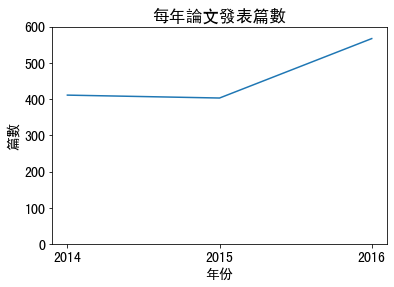

In [6]:
x_year = [2014, 2015, 2016]
plt.plot(year_count['year'], year_count['count'])
plt.title('每年論文發表篇數') # 標題
plt.xlabel('年份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.ylim(0,600) # 刻度
plt.xticks(x_year)
plt.show()

**2.2 NLTK 進行英文斷詞**

In [7]:
# 只抓取論文標題、論文內文
data = metadata[['title','paper_text']]

In [8]:
token_df = data.assign(wordlist = data['paper_text'].apply(nltk.word_tokenize))
token_df.head(3)
# 44s

,title,paper_text,wordlist
0,Bootstrap Model Aggregation for Distributed St...,Bootstrap Model Aggregation for Distributed\nS...,"[Bootstrap, Model, Aggregation, for, Distribut..."
1,large scale canonical correlation analysis wit...,Large Scale Canonical Correlation Analysis wit...,"[Large, Scale, Canonical, Correlation, Analysi..."
2,Robust k-means: a Theoretical Revisit,Robust k-means: a Theoretical Revisit\nAlexand...,"[Robust, k-means, :, a, Theoretical, Revisit, ..."


**2.3 清除停用字**

為了提高準確度，我們會將停用字移除，例如：空格、標點符號、語助詞...等。<br>

In [9]:
# nltk.download('stopwords')

# nltk的stop_words
stop_words = []
stop_words = stopwords.words('english') 
print("將nltk的停用自存為list，並列出前10個停用字：")
print(stop_words[:10])

將nltk的停用自存為list，並列出前10個停用字：
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


除了移除停用字，也可以設定其他條件。
+ 用正規表達式移除標點符號
+ 字的長度要大於一
+ 將所有字轉為小寫
+ 只選沒有在停用字點裡的字

In [10]:
# remove function
def remove(listt):
    result = [re.sub(r'[^\w\s]|\d|_', '', word) for word in listt] #移除標點符號
    result = list(filter(lambda x : len(x)>1, result)) #避免只有單個英文字
    result = [word.lower() for word in result] #將所有字轉為小寫
    result = [word for word in result if not word in stop_words] #移除停用字
    return result

In [11]:
# 套用上面function
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove))
token_df.head(3)

,title,paper_text,wordlist,remove_stopwords
0,Bootstrap Model Aggregation for Distributed St...,Bootstrap Model Aggregation for Distributed\nS...,"[Bootstrap, Model, Aggregation, for, Distribut...","[bootstrap, model, aggregation, distributed, s..."
1,large scale canonical correlation analysis wit...,Large Scale Canonical Correlation Analysis wit...,"[Large, Scale, Canonical, Correlation, Analysi...","[large, scale, canonical, correlation, analysi..."
2,Robust k-means: a Theoretical Revisit,Robust k-means: a Theoretical Revisit\nAlexand...,"[Robust, k-means, :, a, Theoretical, Revisit, ...","[robust, kmeans, theoretical, revisit, alexand..."


**2.4 字詞正規化**

還原字根，通常會搭配Part-of-speech使用。我們同樣的使用NLTK來實作

In [12]:
# 簡易lemma
def lemma(remove_list):
    lem = nltk.stem.WordNetLemmatizer()
    lemma_text = []
    for word in remove_list:
        lemma = lem.lemmatize(word,'v')
        if lemma == word:
            lemma = lem.lemmatize(word,'n')
            if lemma == word:
                lemma = lem.lemmatize(word, 'a')
                lemma_text.append(lemma)
            else:
                lemma_text.append(lemma)
        else:
            lemma_text.append(lemma)

    return lemma_text

In [13]:
# 套用上面function
token_df = token_df.assign( lemma_result = token_df['remove_stopwords'].apply(lemma))
token_df.head(3)

,title,paper_text,wordlist,remove_stopwords,lemma_result
0,Bootstrap Model Aggregation for Distributed St...,Bootstrap Model Aggregation for Distributed\nS...,"[Bootstrap, Model, Aggregation, for, Distribut...","[bootstrap, model, aggregation, distributed, s...","[bootstrap, model, aggregation, distribute, st..."
1,large scale canonical correlation analysis wit...,Large Scale Canonical Correlation Analysis wit...,"[Large, Scale, Canonical, Correlation, Analysi...","[large, scale, canonical, correlation, analysi...","[large, scale, canonical, correlation, analysi..."
2,Robust k-means: a Theoretical Revisit,Robust k-means: a Theoretical Revisit\nAlexand...,"[Robust, k-means, :, a, Theoretical, Revisit, ...","[robust, kmeans, theoretical, revisit, alexand...","[robust, kmeans, theoretical, revisit, alexand..."


## 3. LDA 主題模型

Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文黨集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

**3.1 訓練 LDA 模型**

將文章斷詞結果儲存為 list 資料形態，一篇文章為一個 list ，其中 element 為詞彙。

In [14]:
token_data = token_df['lemma_result'].tolist()

In [15]:
for i in range(0,3):
    print("第 " + str(i+1) + " 篇文章前10個字：")
    for j in range(0,10):
        print(token_data[i][j], end=' ')
    print('\n')

第 1 篇文章前10個字：
bootstrap model aggregation distribute statistical learn jun han department computer 

第 2 篇文章前10個字：
large scale canonical correlation analysis iterative least square yichao lu 

第 3 篇文章前10個字：
robust kmeans theoretical revisit alexandros georgogiannis school electrical computer engineer 



id2word 將斷詞結果生成字典，裡頭為資料集裡出現的字。

In [16]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(42354 unique tokens: ['abstract', 'accord', 'accuracy', 'accurate', 'achieve']...)


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[0]:[(0, 1), (1, 2), (2, 1), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表'abstract'出現一次、'accord'出現兩次、'accuracy'出現一次...以此類推

In [17]:
# 將詞典轉換文檔列表（語料）變成 Document Term Matrix
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 2), (2, 1), (3, 4), (4, 9), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


參數說明：
+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。
因為論文會涵蓋的主題太廣，這邊以生成40個主題為例。

In [18]:
#生成模型 
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=40, # 生成幾個主題數
    random_state=2000, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)
# 1分鐘內跑完

**3.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
(18, '0.023*"asynchronous" + 0.016*"algorithm" + 0.016*"sg"...)<br>
-> 第十九個主題的詞彙分佈，0.023:asynchronous、0.016:algorithm、0.016:sg ...（全部詞彙加起來會等於一）

In [19]:
# 每個主題重要的前五個關鍵字
topics = ldamodel.print_topics(num_words=5)
for topic in topics[0:3]:
    print(topic)

(18, '0.023*"asynchronous" + 0.016*"algorithm" + 0.016*"sg" + 0.016*"et" + 0.016*"al"')
(24, '0.015*"learn" + 0.012*"model" + 0.009*"task" + 0.009*"game" + 0.007*"set"')
(22, '0.010*"information" + 0.009*"time" + 0.008*"process" + 0.008*"function" + 0.007*"market"')


我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題十九：非同步演算法的相關模型
+ 主題二十五：模型學習任務化(task)相關
+ 主題二十三：有關 function 進行時間相關

**3.3 查看 LDA 模型指標**
+ **Pairwise Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [20]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('PMI score: ', PMI_lda)

PMI score:  -0.15748635028525082


In [21]:
perplexity = ldamodel.log_perplexity(corpus)
print('Perplexity Score: ', perplexity)

Perplexity Score:  -7.839176959430319


**3.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>
而因為論文主題本身涵蓋的範圍很廣，因此我們取主題數 40 當作範例來分析

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [23]:
# 這段code會跑很久，同學們可以直接看下面的示意圖即可。

topic_num_list = [5,10,15,20,25,30,35,40,45,50]
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num,
        id2word=id2word,
        random_state = 2021,
        passes=5,
        iterations=1000
    )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "perplexity": tmp_perplexity, "sklearn_perplexity":temp_skleran})


<AxesSubplot:xlabel='topic_num'>

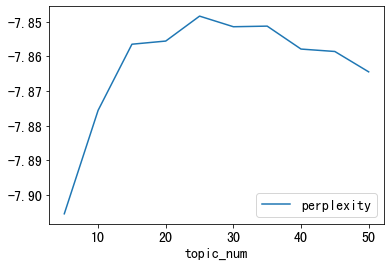

In [24]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')

<AxesSubplot:xlabel='topic_num'>

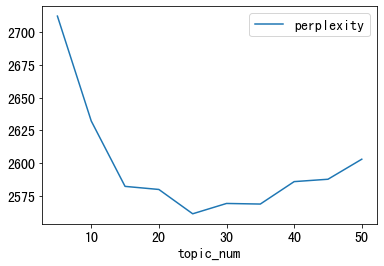

In [25]:
sklearn_plot = pd.DataFrame(result)
sklearn_plot.plot.line(x='topic_num', y='sklearn_perplexity', label='perplexity')

## 4. 視覺化呈現

**4.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 六個主題數，因此有六個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 6 來做 LDAvis 的結果範例，較方便解釋

In [26]:
#生成模型 
ldamodel2 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=6, # 生成幾個主題數
    random_state=2000, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)
# 1分鐘內跑完

In [27]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel2, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis_en.html')

/Users/changfangyu/opt/anaconda3/envs/fanny_nltk/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


**4.2 查看 Document 主題時間上分佈**

使用模型分析我們的資料，取得每篇論文的主題分佈，選最大的設為此文章的主題。<br>
再根據時間來做分析，了解不同的時間點討論的主題大多為什麽，以比例的方式呈現。

In [28]:
# 取得每篇論文的主題分佈
topics_doc = ldamodel2.get_document_topics(corpus)  

# 將結果列成list
doc_list = []

# topics_doc[i] 為第一個文章
for i in range(0,len(topics_doc)):

    # 都先假定第一個主題為最大的
    max_freq = topics_doc[i][0][1]
    max_topic = topics_doc[i][0][0]

    # 後面假如有比較大的就取代
    for j in topics_doc[i]:
        if(j[1] > max_freq):
            max_freq = j[1]
            max_topic = j[0]

    # print(max_topic)
    # print(max_freq)
    doc_list.append(max_topic)

In [29]:
# 將結果放進 DataFrame裏
metadata['topic'] = doc_list

In [30]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':metadata.groupby(['year','topic']).size()
})

date_topic = date_topic.reset_index()

In [31]:
date_df = date_topic.pivot_table(index='year', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['year', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5']
date_df = date_df.set_index('year')
date_df

,topic0,topic1,topic2,topic3,topic4,topic5
year,,,,,,
2014,22,29,32,28,30,13
2015,27,23,26,21,32,19
2016,23,42,34,39,43,17


可以看到在不同時間點，特定主題談論篇幅的多寡

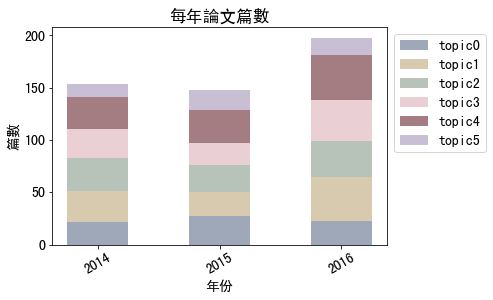

In [32]:
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8", "#EAD0D5", "#A37D81", "#C8BFD4"]
column = ['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5']
temp_bottom = 0

for i in range(0,6):
    if(i>0):
        pass
        temp_bottom = temp_bottom + date_df[column[i-1]]
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], label=column[i] , width=0.5)
        
plt.title('每年論文篇數') # 標題
plt.xticks(x_year)
plt.xlabel('年份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

我們也可以將它轉換為比例來看

In [33]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2 + ratio_df.topic3 + ratio_df.topic4 + ratio_df.topic5  

for i in range(0,6):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

,topic0,topic1,topic2,topic3,topic4,topic5,sum
year,,,,,,,
2014,0.142857,0.188312,0.207792,0.181818,0.194805,0.084416,154
2015,0.182432,0.155405,0.175676,0.141892,0.216216,0.128378,148
2016,0.116162,0.212121,0.171717,0.196970,0.217172,0.085859,198


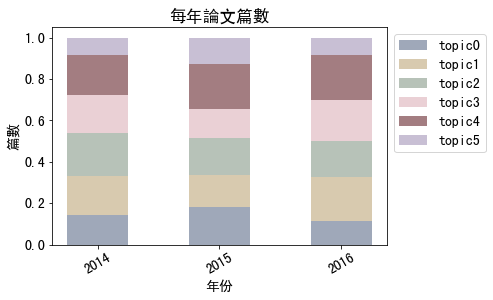

In [34]:
temp_bottom = 0

for i in range(0,6):
    if(i>0):
        temp_bottom = temp_bottom + ratio_df[column[i-1]]
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i], width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], label=column[i], width=0.5)

plt.title('每年論文篇數') # 標題
plt.xticks(x_year)
plt.xlabel('年份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

可以根據上面的圖表推估主題在時間上的變化，但此範例只抓了三個年份，變化上沒有很顯著的改變。

除此之外，我們也可以隨機看一下不同主題大概在談論什麼，是否符合預測。

In [35]:
## 主題一
metadata[metadata['topic'] == 0].sample(n=3)

,id,year,title,event_type,pdf_name,abstract,paper_text,topic
322,6031,2015,Asynchronous stochastic convex optimization: t...,Poster,6031-asynchronous-stochastic-convex-optimizati...,"We show that asymptotically, completely asynch...",Asynchronous stochastic convex optimization:\n...,0
28,5464,2014,Bayesian Inference for Structured Spike and Sl...,Poster,5464-bayesian-inference-for-structured-spike-a...,Sparse signal recovery addresses the problem o...,Bayesian Inference for Structured Spike and\nS...,0
336,5899,2015,Gradient Estimation Using Stochastic Computati...,Poster,5899-gradient-estimation-using-stochastic-comp...,In a variety of problems originating in superv...,Gradient Estimation Using\nStochastic Computat...,0
